<a href="https://colab.research.google.com/github/AnhDao1411/CSC14115/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
from tqdm import tqdm
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
from math import radians, cos, sin, asin, sqrt
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score

import json

In [ ]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 2.5 MB/s 


In [ ]:
%cd /content/drive/MyDrive/CSC14115 - KHDLUD/WEEK/Split_code

/content/drive/.shortcut-targets-by-id/1X9WZOvukNSK-VHf1Vue6YDbHXMF8g2rc/CSC14115 - KHDLUD/WEEK/Split_code


## Modeling


In [ ]:
# Read features.csv
train = pd.read_csv('features_train.csv')
test = pd.read_csv('features_test.csv')

In [ ]:
do_not_use_for_training = ['id','trip_duration']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

In [ ]:
dtrain = train[feature_names]
dtest = test[feature_names]

In [ ]:
y = np.log(train['trip_duration'].values + 1)

In [ ]:
# Checking columns that contain null values
dtrain.isnull().sum()

vendor_id                                          0
passenger_count                                    0
pickup_longitude                                   0
pickup_latitude                                    0
dropoff_longitude                                  0
dropoff_latitude                                   0
pick_month                                         0
hour                                               0
day_of_month                                       0
day_of_week                                        0
distance_haversine                                 0
distance_manhattan                                 0
direction                                          0
pickup_cluster                                     0
dropoff_cluster                                    0
avg_speed_h_hour_pickup_cluster                23193
cnt_hour_pickup_cluster_x                      23193
avg_speed_h_hour_dropoff_cluster               23058
cnt_hour_dropoff_cluster_x                    

### Linear Regression

#### Preprocessor

In [ ]:
num_cols = list(dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(dtrain.select_dtypes(include='object').columns)

#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("imputer", SimpleImputer(strategy="mean")),
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dtrain, y, test_size=0.2, random_state=1987)

#### Training

In [ ]:
model_linear = LinearRegression()

# giving all values to pipeline
linear_pipe = Pipeline(steps=[('preprocessor', preprocessor),('linear', model_linear)])
linear_pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = linear_pipe.predict(X_val)

In [ ]:
print(linear_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('norm',
                                                                   StandardScaler())]),
                                                  ['vendor_id',
                                                   'passenger_count',
                                                   'pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'pick_month', 'hour',
                                                   'day_of_month',
                          

In [ ]:
# to print the results in good way
print(f"Validation RMSLE: {mean_squared_error(y_pred, y_val, squared=False)}")

Validation RMSLE: 0.6959264826704723


In [ ]:
y_pre_linear = linear_pipe.predict(test)
y_pre_linear = np.exp(y_pre_linear) - 1
y_pre_linear

array([ 799.47155864,  622.09262246,  386.19006819, ..., 1165.45078033,
       2521.36812958,  792.47300572])

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = y_pre_linear
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,799.471559
1,id3505355,622.092622
2,id1217141,386.190068
3,id2150126,897.227197
4,id1598245,384.108937


In [ ]:
new_df.to_csv("submission_linear.csv", index = False)

* **Week 10**

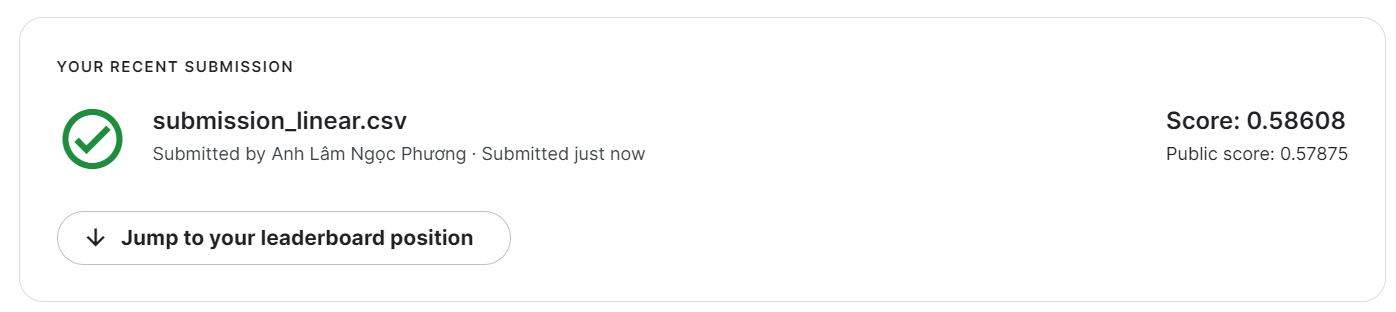

* **Week 11**
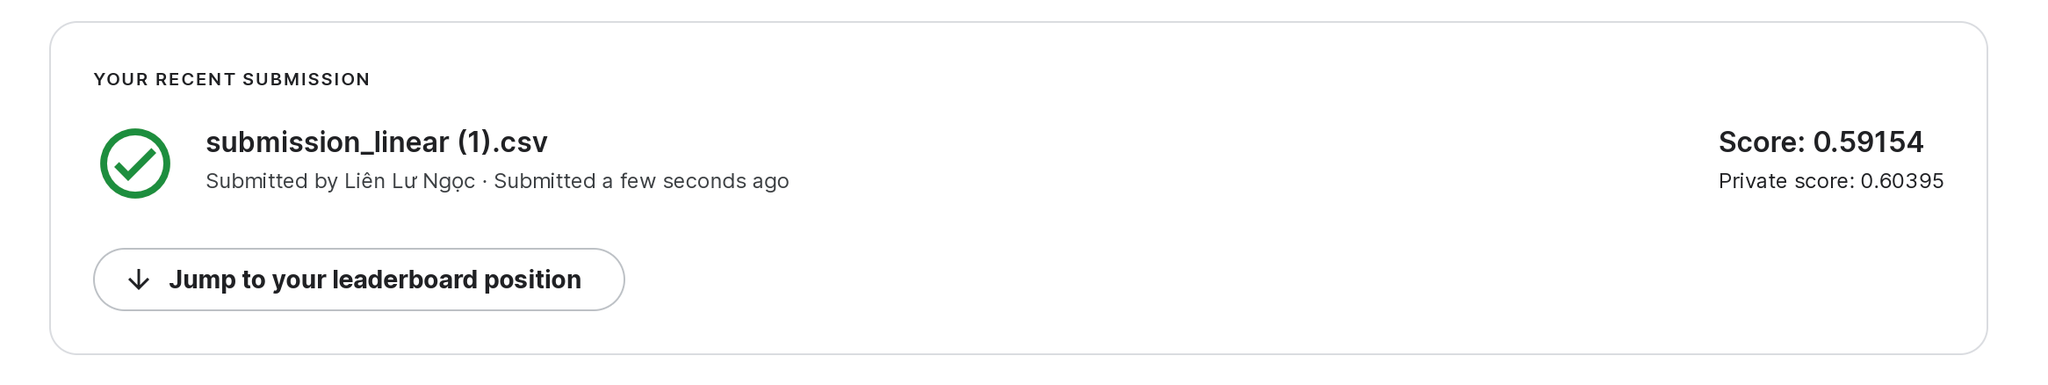

### XGB

**Gradient Boosting**

An emsemble method, it temps to build a stronger model from a week model sequentially. The second model is learned from the errors present in the first model.


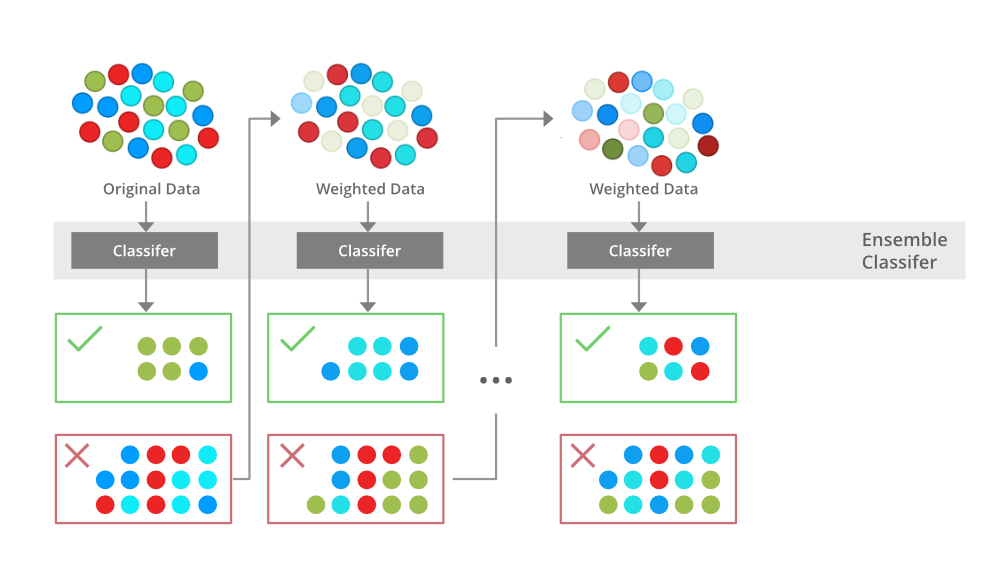

Boosting classifier

image source: [Geeksforgeeks, @pawangfg, xgboost](https://www.geeksforgeeks.org/xgboost/)

Below steps describe the sequential training:


1.   Fit a decision tree to the original data: $P_1(x) = y$
  * $P_1$: is the model needs to learn 
  * $x$: samples, $y$: target labels
2.   Then, fit the next new tree to the errros/residuals of previous tree: $h_1(x) = y-P_1(x)$ 
3. Add the new tree to the current model: $P_2(x) = P_1(x)+\epsilon*h_1(x)$ 
  * $\epsilon$: is learning rate
4. Then, fit new tree to the previous's erros: $h_2(x)=y-P_2(x)$
5. Add to current model: $P_3(x)=P_2(x)+h_2(x)$
6. Continue this process until the maximum tree is reached or the loss is converged

Basic GBM $\to$ Stochastic GBM (subsample rows/cols) $\to$ XGBoost

**XGBoost**: is an optimized gradient boosting model that provides efficient, flexible and multiple languages,... 

#### Preprocessor

XGB supports to handle missing values by default. In training time, XGB will choose left/right node for nan to minimise the loss.

In [ ]:
num_cols = list(dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(dtrain.select_dtypes(include='object').columns)

#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dtrain, y, test_size=0.2, random_state=1987)

#### Our training

Hyperparameters will focus on 3 categories:





**General parameters**: guide the overall functioning of the XGBoost model

  1. booster: `gbtree` and `dart` - use tree-based models, while `gblinear` uses linear models.

**Booster parameters**
3. eta: learning rate. This parameter is used for slowing down the speed of learning and reducing overfitting. If this is too low, we will take more time waiting for the model to converge and for more trees to be added to the model. If this is too high, the model will pass the converging point. The range of learning rate is typically used to tune from 0.01 to 0.3.

4. max_depth: the maximum depth of a tree (depending on what depth we want the tree is, tuning this parameter to get the best). Smaller depth trees are computationally efficient but require more trees. The higher depth trees will capture unique interactions but also increase the possibility of being overfitted.

4. min_child_weight: in regression task, it's the minimum number of samples needed in each node. High min_child_weight makes the model more conservative.

5. subsample: a ratio of the training instances. XGB will collect randomly a part of dataset for building tree to prevent overfitting.

6. colsample_bytree: the subsample ratio of columns when constructing each tree

7. lambda: use to handle the regulazation part of XGB. If lambda is too high, the model wont learn enough about the training data to make good prediction $→$ underfit. If lambda is too small, the model will be complex, learn too much about particularities the training data $→$ overfit



**Learning task parameters**

Paramaters that using in optimization
8. objective: the loss function 
2. eval_metric: metric for validation data


In [ ]:
my_pipeline = Pipeline(steps=[('preprocessor',preprocessor)])

# Transform the data
X_train_xgb = my_pipeline.fit_transform(X_train)
X_val_xgb = my_pipeline.transform(X_val)

dtrain_ = xgb.DMatrix(X_train_xgb, label=y_train)
dvalid_ = xgb.DMatrix(X_val_xgb, label=y_val)
watchlist = [(dtrain_, 'train'), (dvalid_, 'valid')]

#####**learning rate**

In [ ]:
best = 100
dic = {}
for ETA in tqdm([0.05, 0.1, 0.15, 0.3]):
    
    xgb_pars = {'eta': ETA, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        lr = ETA
dic['eta'] = lr

In [ ]:
print(best)

##### **min child weight**

In [ ]:
mcw = 1
for MCW in tqdm([50, 100]):
    xgb_pars = {'eta': lr, 'min_child_weight': MCW, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        mcw = MCW
dic['min_child_weight'] = mcw

print(best)

##### **colsample_bytree**

In [ ]:
cs = 1
for CS in tqdm([0.3, 0.4, 0.5]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': CS, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        cs = CS
dic['colsample_bytree'] = cs
print(best)

##### **max_depth**

In [ ]:
md = 6
for MD in tqdm([8, 10]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': cs,
                'max_depth': MD, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        md = MD
dic['max_depth'] = md
print(best)

##### **subsample**

In [ ]:
ss = 1
for SS in tqdm([0.5, 0.8]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': cs, 'subsample': SS,
                'max_depth': md, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        ss = SS
dic['subsample'] = ss
print(best)

##### **lambda**

In [ ]:
ld = 1
for LAMBDA in tqdm([0.5, 1.5]):
    xgb_pars = {'eta': lr, 'min_child_weight': mcw, 'colsample_bytree': cs, 'subsample': ss,
                'lambda': LAMBDA, 'max_depth': md, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    model = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)
    if (model.best_score < best):
        best = model.best_score
        ld = LAMBDA
dic['lambda'] = ld
print(best)

##### Result

In [ ]:
# with open('tun_AD.txt', 'w') as tun:
#      tun.write(json.dumps(dic))

In [ ]:
with open('../../tun_AD.txt') as f:
    tun = json.load(f)
tun

{'colsample_bytree': 1,
 'eta': 0.3,
 'lambda': 1,
 'max_depth': 10,
 'min_child_weight': 1,
 'subsample': 1}

In [ ]:
model_xgb_tun = xgb.train(tun, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

Exception ignored in: <function Booster.__del__ at 0x7f70d4a03170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


[0]	train-rmse:4.22547	valid-rmse:4.22686
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.409365	valid-rmse:0.427937
[20]	train-rmse:0.370278	valid-rmse:0.404308
[30]	train-rmse:0.358585	valid-rmse:0.402414
[40]	train-rmse:0.349034	valid-rmse:0.400074
[50]	train-rmse:0.341474	valid-rmse:0.398689
[59]	train-rmse:0.335869	valid-rmse:0.398321


In [ ]:
print('Modeling RMSLE %.5f' % model_xgb_tun.best_score)

Modeling RMSLE 0.39832


In [ ]:
dtest_ = my_pipeline.transform(dtest)
dtest_ = xgb.DMatrix(dtest_)
y_pre_xgb = model_xgb_tun.predict(dtest_)
y_pre_xgb

array([6.6857886, 6.314223 , 6.0938263, ..., 7.448591 , 7.6777635,
       6.953228 ], dtype=float32)

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = np.exp(y_pre_xgb) - 1
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,799.942078
1,id3505355,551.372620
2,id1217141,442.113647
3,id2150126,976.050781
4,id1598245,425.410004


In [ ]:
new_df.to_csv("submission_xgb_tun.csv", index = False)

* **Week 10**
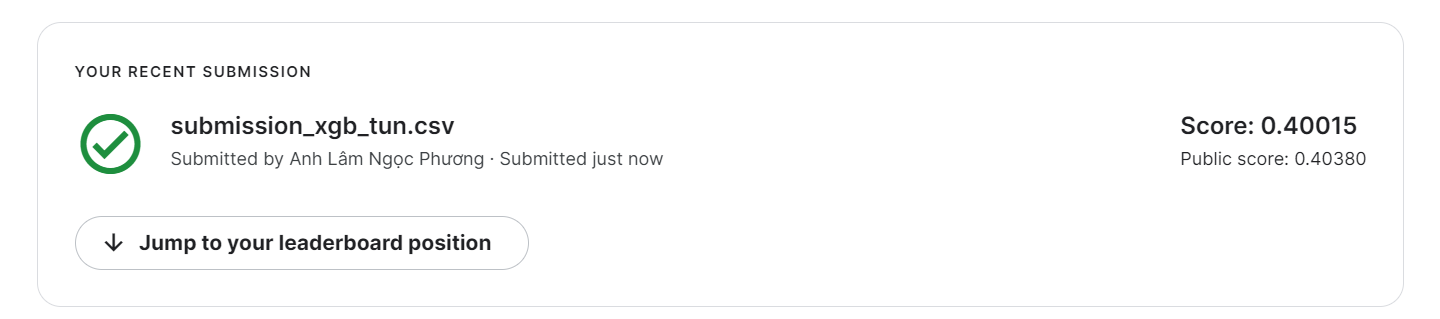

* **Week 11**
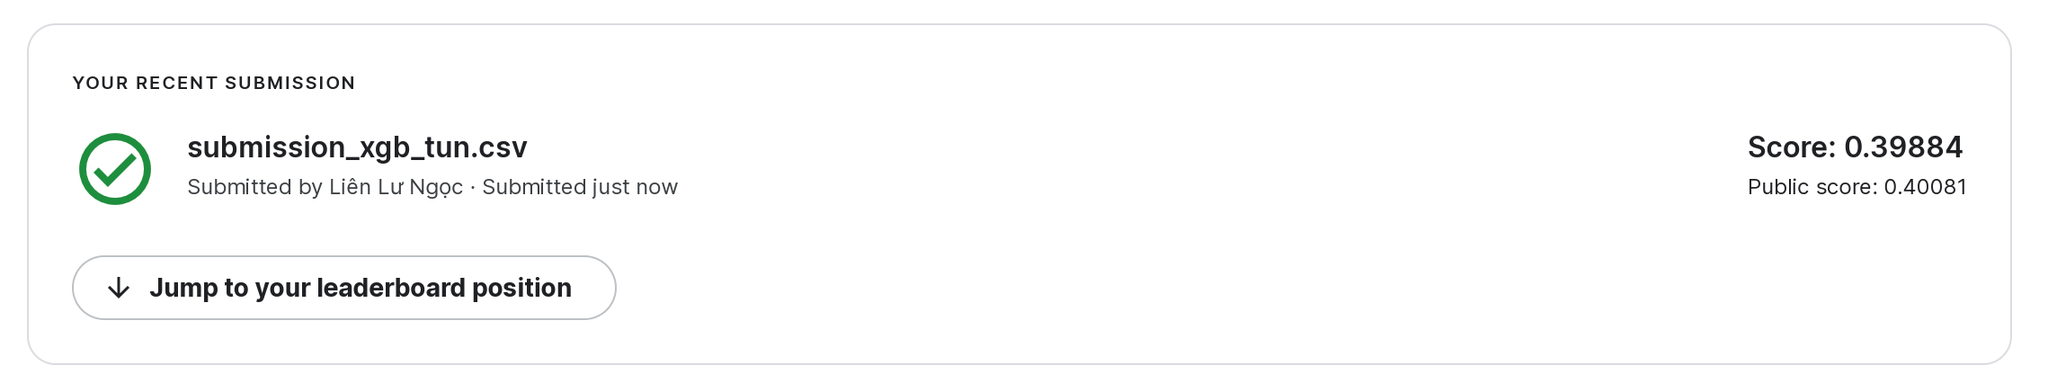

##### Features importance

In [ ]:
feature_importance_dict = model_xgb_tun.get_score(importance_type="total_cover")
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)
feature_importance['importance'] = feature_importance['importance']/ feature_importance['importance'].sum()

feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

,feature_name,importance
10,distance_haversine,0.137317
5,dropoff_latitude,0.077652
4,dropoff_longitude,0.069642
11,distance_manhattan,0.068546
3,pickup_latitude,0.058220
2,pickup_longitude,0.058067
9,day_of_week,0.053456
7,hour,0.050793
22,avg_speed_m_hour_dropoff_cluster,0.048135
18,cnt_hour_dropoff_cluster_x,0.042682


Ref: https://stats.stackexchange.com/questions/396986/feature-selection-meaning-of-importance-type-in-get-score-function-of-xgbo

**get_score(fmap=' ', importance_type='total_cover')** \
Calculate the feature important

'total_cover' means: when the tree is splitted by a features. the number of rows will be splitted by conditions. total_cover will calculate the sum of rows which each branch/feature of tree is used. 

* **Observations**
    * As expected, distance has a significant impact on trip duration. Besides that, the group of location/ area and direction let us know whether the destination will be crowded or not to estimate the time correctly.
    * As we visualised before, the hour and day of the month let us know more about congestion.
    * The count of trip records when grouped by pickup cluster and dropoff cluster is seen not good as expected. It just counts the id having the same pickup and dropoff location without caring about the situation (the hour, the day,…).

#### Refering Beluga's notebook

In [ ]:
# # Data preprocessing pipeline
# my_pipeline = Pipeline(steps=[('preprocessor',preprocessor)])

# # Transform the data
# X_train_xgb = my_pipeline.fit_transform(X_train)
# X_val_xgb = my_pipeline.transform(X_val)

In [ ]:
# dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
# dvalid = xgb.DMatrix(X_val_xgb, label=y_val)
# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
model_xgb = xgb.train(xgb_pars, dtrain_, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.22655	valid-rmse:4.22777
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.431913	valid-rmse:0.442113
[20]	train-rmse:0.395985	valid-rmse:0.411862
[30]	train-rmse:0.387712	valid-rmse:0.407438
[40]	train-rmse:0.381907	valid-rmse:0.405613
[50]	train-rmse:0.378649	valid-rmse:0.404543
[59]	train-rmse:0.375725	valid-rmse:0.404009


In [ ]:
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.40398


In [ ]:
dtest_ = my_pipeline.transform(dtest)
dtest_ = xgb.DMatrix(dtest_)
y_pre_xgb = model_xgb.predict(dtest_)
y_pre_xgb

array([6.715346 , 6.389314 , 6.1034837, ..., 7.3298335, 7.5525737,
       7.029914 ], dtype=float32)

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = np.exp(y_pre_xgb) - 1
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,823.969055
1,id3505355,594.448059
2,id1217141,446.413696
3,id2150126,1082.173950
4,id1598245,359.404724


In [ ]:
new_df.to_csv("submission_xgb.csv", index = False)

* **Week10**

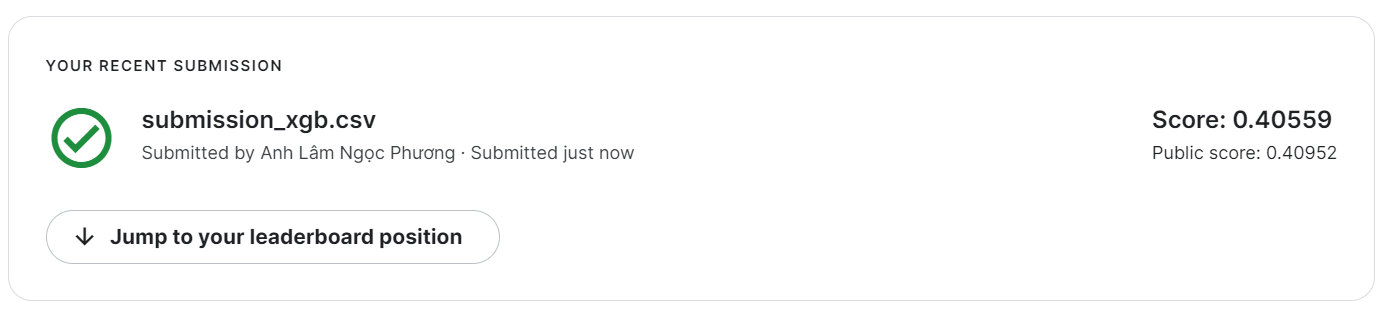

* **Week 11**
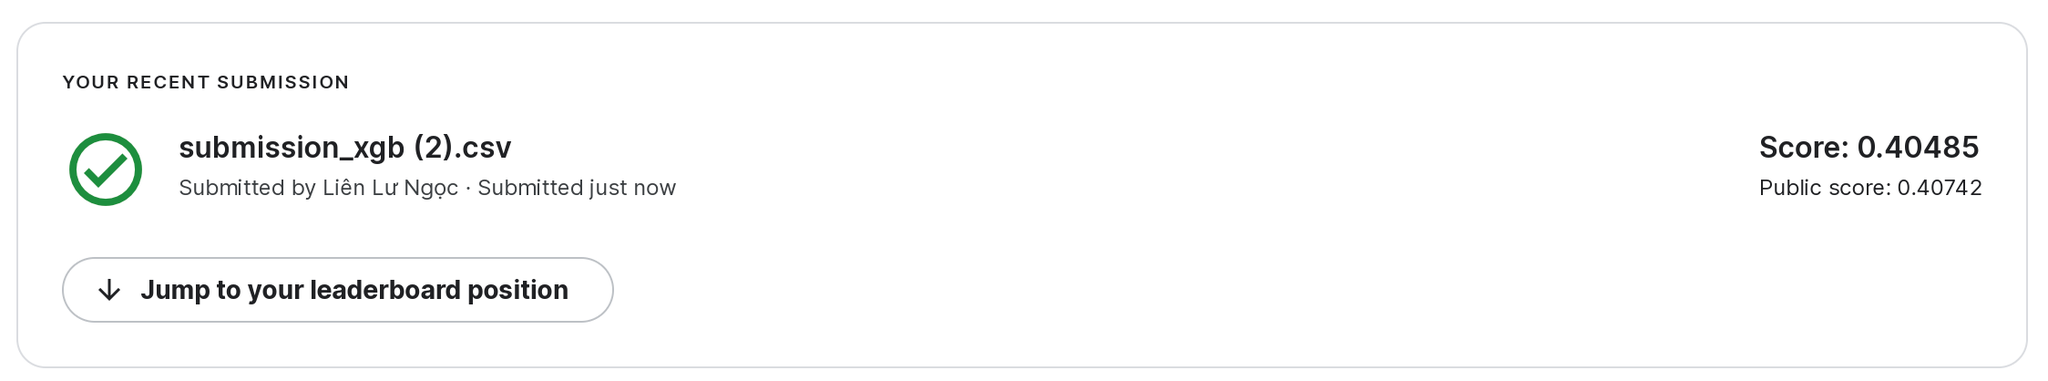

### Stacking model 

In [ ]:
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_regression
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import StackingRegressor
# from matplotlib import pyplot

In [ ]:
# # get a stacking ensemble of models
# def get_stacking():
# 	# define the base models
# 	level0 = list()
# 	level0.append(('xgb', xgb.XGBRegressor()))
# 	# level0.append(('random', RandomForestRegressor()))
# 	# level0.append(('extra', ExtraTreesRegressor()))
# 	# level0.append(('cart', DecisionTreeRegressor()))
# 	level0.append(('linear', LinearRegression()))
# 	# define meta learner model
# 	level1 = xgb.XGBRegressor()
# 	# define the stacking ensemble
# 	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# 	return model

In [ ]:
# model = get_stacking()    
# # giving all values to pipeline 
# stack_pipe = Pipeline(steps=[('preprocessor', preprocessor),('stack', model)])

# stack_pipe.fit(X_train, y_train)

# # make predictions on training set
# y_pred_stack = stack_pipe.predict(X_val)

In [ ]:
# # to print the results in good way
# print(f"Validation RMSLE: {mean_squared_error(y_pred_stack, y_val, squared=False)}")

In [ ]:
# y_pre_stack_test = stack_pipe.predict(test)

In [ ]:
# y_pre_stack_test

In [ ]:
# new_df = test.copy()
# new_df['trip_duration'] = np.exp(y_pre_stack_test) - 1
# new_df = new_df[['id', 'trip_duration']]
# new_df.head()

In [ ]:
# new_df.to_csv("submission_stack_xgb_linear.csv", index = False)

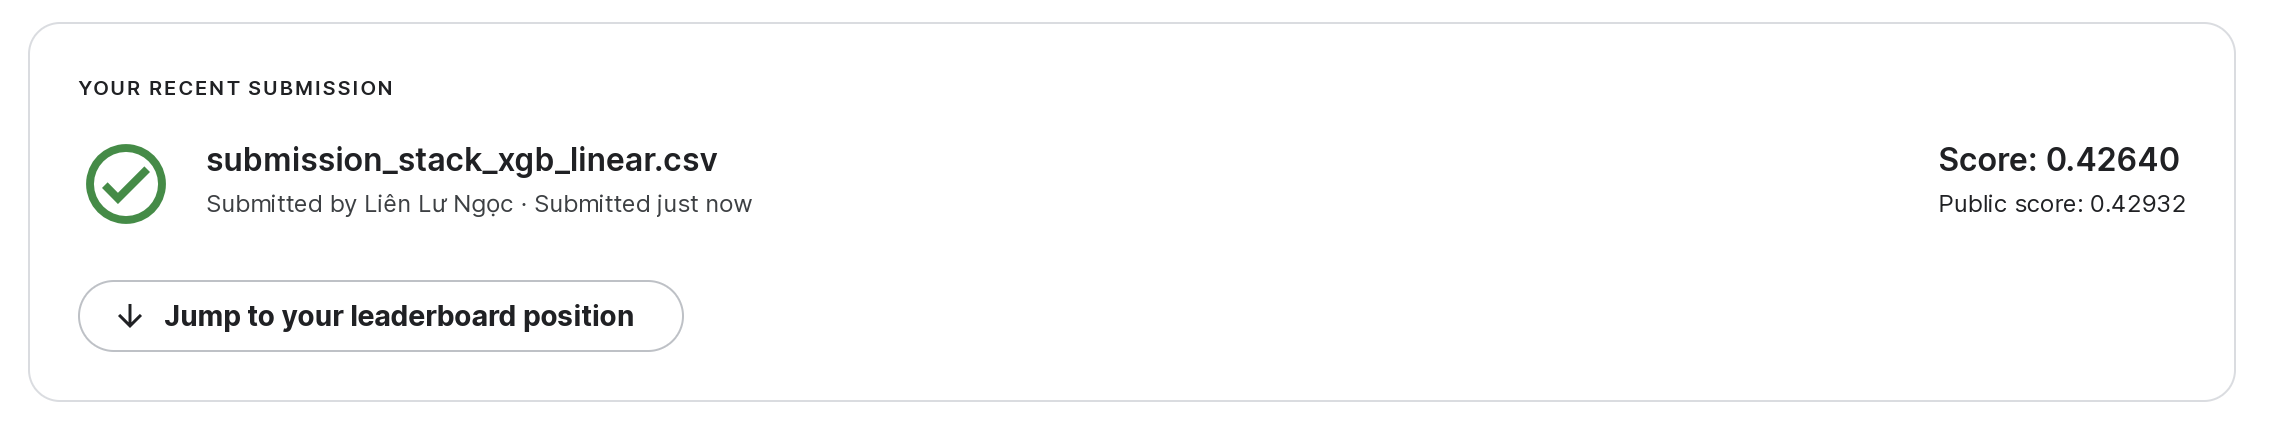

## Improve model with auxiliary dataset
Based on the important features of XGB, we know that distance has the strongest affect on predicting the trip_duration. $\to$ we decide to use the additional OSRM dataset.

OSRM features - Open Source Routing Machine is a routing engine to extract shortest paths in road networks for each trip (with pickup and dropoff location). 

In [ ]:
osrm_train = pd.read_csv('../../nyc-taxi-trip-noisy/train_augmented.csv')
osrm_test = pd.read_csv('../../nyc-taxi-trip-noisy/test_augmented.csv')
print("OSRM Train shape: ", osrm_train.shape)
print("OSRM Test shape: ", osrm_test.shape)

OSRM Train shape:  (1458643, 16)
OSRM Test shape:  (625134, 16)


* Definition of each column

| Column name | Description | 
| -------- | -------- | 
| id   | Record id     |
| distance | Route distance (m) |
| duration | OSRM trip duration (s) |
| motorway | The proportion spent on different kind of roads (% of total distance) |
| trunk |  The proportion spent on different kind of roads (% of total distance) |
| primary | The proportion spent on different kind of roads (% of total distance) |
| secondary | The proportion spent on different kind of roads (% of total distance) |
| tertiary | The proportion spent on different kind of roads (% of total distance) |
| unclassified | The proportion spent on different kind of roads (% of total distance) |
| residential | The proportion spent on different kind of roads (% of total distance) |
| nTrafficSignals | The number of traffic signals |
| nCrossing | The number of pedestrian crossing |
| nStop | The number of stop signs |
| nIntersection | The number of intersections, if you are OSRM user, intersection have different meaning than the one used in OSRM |
| srcCounty | Pickup county |
| dstCounty | Dropoff county |

* **srcCounty** and **dstCounty** values: There are 6 different values
    * NA: Not in NYC
    1. Brooklyn
    2. Queens
    3. Staten Island
    4. Manhattan
    5. Bronx

$\Rightarrow$ We will fill in NA values with the number 6.

Based on the column definition, we will keep features that we need for the problem

In [ ]:
osrm_features = ["id", "distance"]

In [ ]:
osrm_train = osrm_train[osrm_features]
osrm_test = osrm_test[osrm_features]

In [ ]:
osrm_train.dtypes

id           object
distance    float64
dtype: object

In [ ]:
osrm_test.dtypes

id           object
distance    float64
dtype: object

In [ ]:
osrm_train.head(2)

,id,distance
0,id2875421,2009.1
1,id2377394,2513.4


In [ ]:
print(len(np.intersect1d(osrm_train['id'], train['id'])))
print(train.shape[0])

1458643
1458644


* The number of ids in osrm_train is less than the origin train set 1 id, every id in osrm_train are in train set.

In [ ]:
osrm_num_cols = list(osrm_train.select_dtypes(exclude = 'object').columns)
osrm_cate_cols = list(osrm_train.select_dtypes(include = 'object').columns)

In [ ]:
# osrm_train[osrm_num_cols].agg([missing_percentage, value_percentages, num_values])

In [ ]:
osrm_train = osrm_train.merge(train, on = 'id')
osrm_test = osrm_test.merge(test, on = 'id')

In [ ]:
osrm_dtrain = osrm_train[feature_names]
osrm_dtest = osrm_test[feature_names]

In [ ]:
osrm_y = np.log(osrm_train['trip_duration'].values + 1)

### Preprocessor

In [ ]:
num_cols = list(osrm_dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(osrm_dtest.select_dtypes(include='object').columns)

In [ ]:
#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])

X_train, X_val, y_train, y_val = train_test_split(osrm_dtrain, osrm_y, test_size=0.2, random_state=1987)

### XGB

In [ ]:
my_pipeline = Pipeline(steps=[('preprocessor',preprocessor)])

# Transform the data
X_train_xgb = my_pipeline.fit_transform(X_train)
X_val_xgb = my_pipeline.transform(X_val)

dtrain_ = xgb.DMatrix(X_train_xgb, label=y_train)
dvalid_ = xgb.DMatrix(X_val_xgb, label=y_val)
watchlist = [(dtrain_, 'train'), (dvalid_, 'valid')]

In [ ]:
with open('../../tun_AD.txt') as f:
    tun = json.load(f)
tun

{'colsample_bytree': 1,
 'eta': 0.3,
 'lambda': 1,
 'max_depth': 10,
 'min_child_weight': 1,
 'subsample': 1}

In [ ]:
model_xgb_tun = xgb.train(tun, dtrain_, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

[0]	train-rmse:4.22557	valid-rmse:4.22636
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.410033	valid-rmse:0.425635
[20]	train-rmse:0.371168	valid-rmse:0.402036
[30]	train-rmse:0.357792	valid-rmse:0.398552
[40]	train-rmse:0.349158	valid-rmse:0.397034
[50]	train-rmse:0.340556	valid-rmse:0.396012
[59]	train-rmse:0.335588	valid-rmse:0.395358


In [ ]:
print('Modeling RMSLE %.5f' % model_xgb_tun.best_score)

Modeling RMSLE 0.39536


In [ ]:
dtest_ = my_pipeline.transform(osrm_dtest)
dtest_ = xgb.DMatrix(dtest_)
y_pre_xgb = model_xgb_tun.predict(dtest_)
y_pre_xgb

array([6.7447925, 6.4568505, 6.0840235, ..., 7.445426 , 7.6395698,
       6.818217 ], dtype=float32)

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = np.exp(y_pre_xgb) - 1
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,848.622803
1,id3505355,636.051514
2,id1217141,437.791107
3,id2150126,969.960205
4,id1598245,345.871429


In [ ]:
new_df.to_csv("submission_xgb_tun_osrm.csv", index = False)

*   Week 10
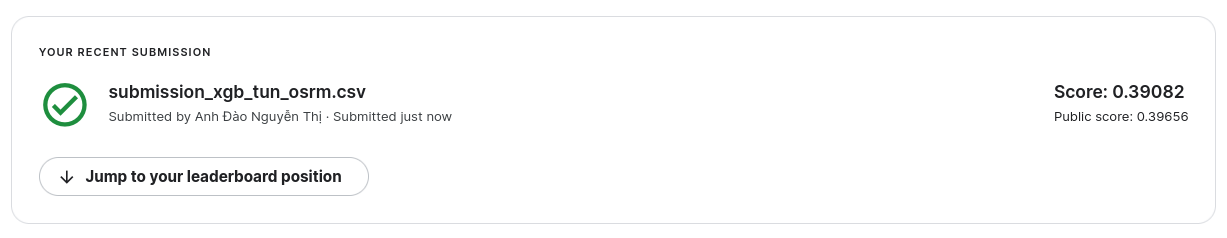



* **Week 11**
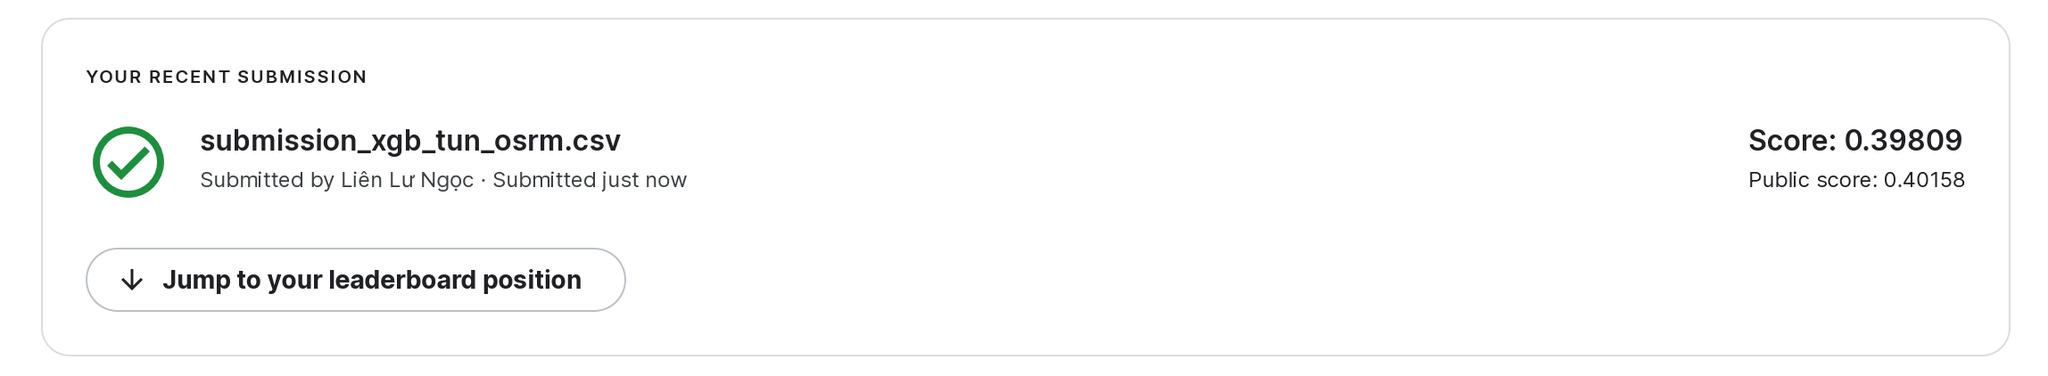

In [ ]:
model_xgb_tun = xgb.train(tun, dtrain_, 150, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

[0]	train-rmse:4.22557	valid-rmse:4.22636
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.410033	valid-rmse:0.425635
[20]	train-rmse:0.371168	valid-rmse:0.402036
[30]	train-rmse:0.357792	valid-rmse:0.398552
[40]	train-rmse:0.349158	valid-rmse:0.397034
[50]	train-rmse:0.340556	valid-rmse:0.396012
[60]	train-rmse:0.334891	valid-rmse:0.395301
[70]	train-rmse:0.329549	valid-rmse:0.394571
[80]	train-rmse:0.324028	valid-rmse:0.393954
[90]	train-rmse:0.319042	valid-rmse:0.39359
[100]	train-rmse:0.314742	valid-rmse:0.393406
[110]	train-rmse:0.309857	valid-rmse:0.393132
[120]	train-rmse:0.305845	valid-rmse:0.393178
[130]	train-rmse:0.302746	valid-rmse:0.393085
[140]	train-rmse:0.299205	valid-rmse:0.393001
[149]	train-rmse:0.296882	valid-rmse:0.392981


In [ ]:
print('Modeling RMSLE %.5f' % model_xgb_tun.best_score)

Modeling RMSLE 0.39292


In [ ]:
dtest_ = my_pipeline.transform(osrm_dtest)
dtest_ = xgb.DMatrix(dtest_)
y_pre_xgb = model_xgb_tun.predict(dtest_)
y_pre_xgb

array([6.7181067, 6.430483 , 6.0424604, ..., 7.529732 , 8.127862 ,
       6.793506 ], dtype=float32)

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = np.exp(y_pre_xgb) - 1
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,826.249817
1,id3505355,619.473450
2,id1217141,419.927429
3,id2150126,1029.480347
4,id1598245,360.488678


In [ ]:
new_df.to_csv("submission_xgb_tun_osrm_150.csv", index = False)

* **Week 11**
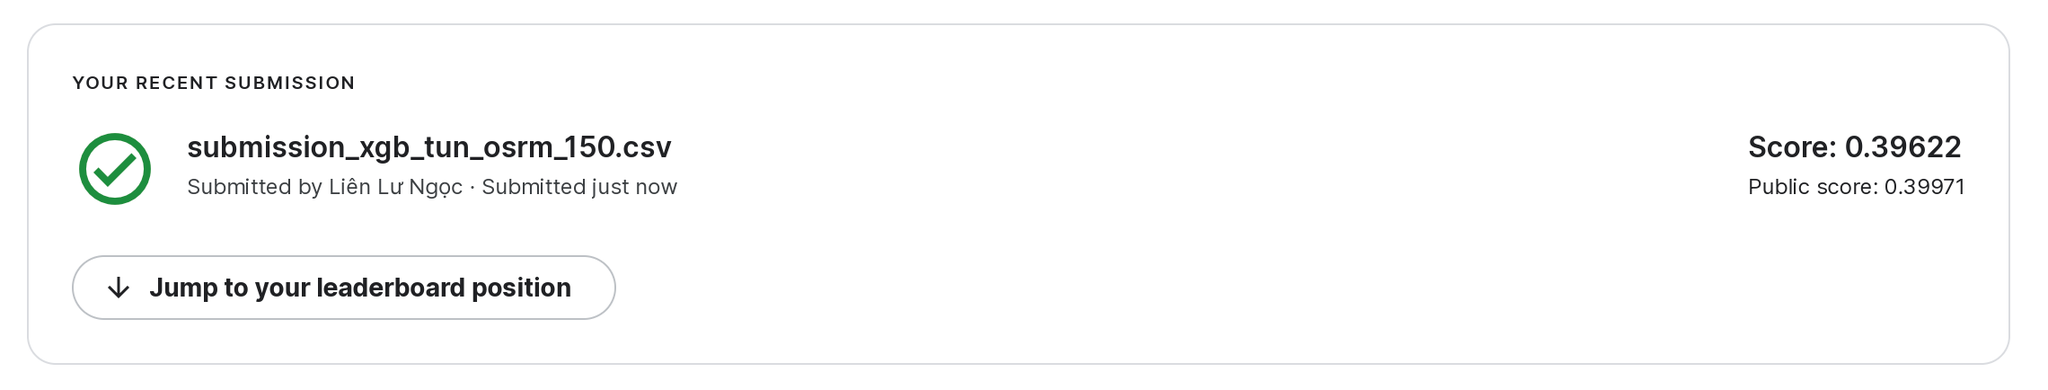

## Reference

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error

https://www.geeksforgeeks.org/xgboost/

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

https://www.kaggle.com/code/felipefiorini/xgboost-hyper-parameter-tuning 

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error

https://www.geeksforgeeks.org/xgboost/

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

https://www.kaggle.com/code/felipefiorini/xgboost-hyper-parameter-tuning 

https://www.rdocumentation.org/packages/xgboost/versions/1.6.0.1/topics/xgb.train (read for hyper para)

https://bradleyboehmke.github.io/HOML/gbm.html#prerequisites-10